In [3]:
#bring in a las file
import lasio
l = lasio.read("1044966704.las")

In [11]:
#looking at the well header
l.well
#looking at the other header units
l.params

[HeaderItem(mnemonic=RUN, unit=, value=1, descr=Run number, original_mnemonic=RUN),
 HeaderItem(mnemonic=GL, unit=Ft, value=1205.0, descr=Ground level elevation, original_mnemonic=GL),
 HeaderItem(mnemonic=DREF, unit=, value=KB, descr=Depth reference, original_mnemonic=DREF),
 HeaderItem(mnemonic=EREF, unit=Ft, value=1215.0, descr=Elevation of depth reference, original_mnemonic=EREF),
 HeaderItem(mnemonic=TDL, unit=Ft, value=0.0, descr=Total depth, logger, original_mnemonic=TDL),
 HeaderItem(mnemonic=TDD, unit=Ft, value=0.0, descr=Total depth, driller, original_mnemonic=TDD),
 HeaderItem(mnemonic=CSGL, unit=Ft, value=0.0, descr=Casing bottom, logger, original_mnemonic=CSGL),
 HeaderItem(mnemonic=CSGD, unit=Ft, value=0.0, descr=Casing bottom, driller, original_mnemonic=CSGD),
 HeaderItem(mnemonic=CSGS, unit=In, value=8.625, descr=Casing size, original_mnemonic=CSGS),
 HeaderItem(mnemonic=CSGW, unit=Lbs, value=20.0, descr=Casing weight, original_mnemonic=CSGW),
 HeaderItem(mnemonic=BS, u

In [12]:
#plot out all the curves, units, names etc in readable format
#straight from https://pypi.python.org/pypi/lasio/0.7.6
for curve in l.curves:
...     print("%s\t[%s]\t%s\t%s" % (
...         curve.mnemonic, curve.unit, curve.value, curve.descr))

DEPT	[FEET]	00 001 00 00	Measured Depth
DT	[us/ft]	60 520 32 00	Compensated Sonic Delta Time (uS/Foot)
CILD	[mMHO]	07 110 45 00	Deep Induction R Conductivity
CALN	[in]	45 280 24 00	Compensated Neutron Caliper (Diameter)
CALD	[in]	45 280 13 00	Litho Caliper (Diameter)
GR	[gAPI]	07 310 01 00	Gamma Ray - API Units
ILD	[ohm/m]	07 120 45 00	Phased Deep Induction Resistivity
ILM	[ohm/m]	07 120 44 00	Phased Medium Induction Resistivity
LWTLB	[lb]	00 000 00 00	Line Weight Filtered (lbs)
CALM	[in]	07 280 12 00	Micro Spherically Focused Tool (MST-DA) Caliper (Diameter)
NPLS	[%]	42 330 01 00	Compensated Neutron Porosity (NAPI, Limestone Matrix)
DPLS	[%]	45 890 10 00	Lithology Density Porosity (Matrix Density 2.71 g/cc)
PORS	[%]	60 520 30 00	Sonic Derived Porosity
SFL	[ohm/m]	07 220 04 00	Spherically Focused Resistivity, Environmentally Corrected
SP	[mV]	07 010 01 00	Spontaneous Potential (Processed, Internally Calibrated)
TT1	[us]	60 520 32 00	Travel Time (Filtered Heavier) (Transmitter 1 - Recei

In [91]:
#grab out some logs
depth = l["DEPT"]
gr = l["GR"]
sp = l["SP"]
pe = l["PE"]
rhob = l["RHOB"]

cali1 = l["CALN"]
cali2 = l["CALD"]
cali3 = l["CALM"]


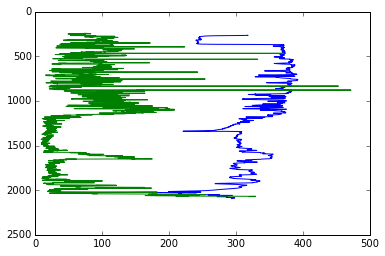

In [93]:
#then plot up multiple logs versus a depth axis
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

log1 = sp
log2 = gr

plt.plot(log1, depth)
plt.plot(log2, depth)
#go and get the y(depth) auto min and max from the plot
ymin, ymax = plt.ylim()
#then reverse them so depth increases downwards
plt.ylim( (ymax, ymin))
plt.show()


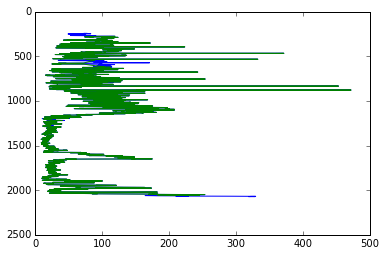

In [87]:
#clean up logs where caliper <> casing size

casing_param = l.params["CSGS"]
casing = casing_param.value
#if you don't have a header or you have multiple casings casing = Y

log = gr
cali = cali1
#cali_slop is the margin of error you will allow between caliper and casing size (in casing units)
cali_slop = .5

log_clean_cali = log[abs(cali-casing) < cali_slop]
depth_clean_cali = depth[abs(cali-casing) < cali_slop]

plt.plot(log, depth)
plt.plot(log_clean_cali, depth_clean_cali)
ymin, ymax = plt.ylim()
#then reverse them so depth increases downwards
plt.ylim( (ymax, ymin))
plt.show()

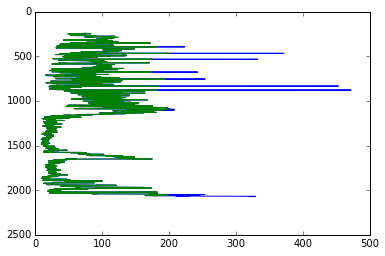

In [72]:
#this is a really rough attempt at despiking a single log based on a cut at mean+- X*std_deviation

log = gr

#get rid of nan's from a log with an inverse (~) of the isnan
log_nonan = log[~np.isnan(log)]
depth_nonan = depth[~np.isnan(log)]

#calculate mean and std
log_mean = np.mean(log_nonan)
log_std = np.std(log_nonan)

#get rid of log spikes that fall outside the mean+-X*stdev
X = 2.5
log_Xstd = abs((log_nonan - log_mean))/log_std
log_nospikes = log_nonan[log_Xstd<X]
depth_nospikes = depth_nonan[log_Xstd<X]

plt.plot(log, depth)
plt.plot(log_nospikes, depth_nospikes)
ymin, ymax = plt.ylim()
#then reverse them so depth increases downwards
plt.ylim( (ymax, ymin))
plt.show()

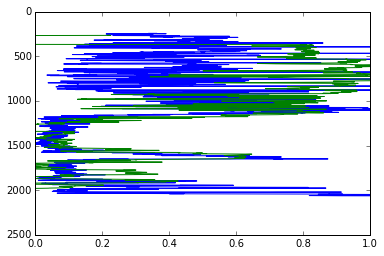

In [110]:
#simple attempt at Vsh from both GR and SP

gr_min = min(gr[~np.isnan(gr)])

#could just grab gr_max, but this will be a problem if spikes are present
gr_max = max(gr[~np.isnan(gr)])

#another method is to take gr_max as mean+3 std dev
gr_mean = np.mean(gr[~np.isnan(gr)])
gr_std = np.std(gr[~np.isnan(gr)])
gr_max_no_spikes = gr_mean+(3*gr_std)

#or use a percentile filter
pct_cut = 98
gr_max_pct = np.nanpercentile(gr,pct_cut)

VSH_gr = (gr - gr_min) / (gr_max_pct - gr_min)


sp_min = min(sp[~np.isnan(sp)])
sp_max = max(sp[~np.isnan(sp)])
#or use a percentile filter
max_pct_cut = 98
min_pct_cut = 20
sp_min_pct = np.nanpercentile(sp,min_pct_cut)
sp_max_pct = np.nanpercentile(sp,max_pct_cut)

VSH_sp = (sp - sp_min_pct) / (sp_max_pct - sp_min_pct)


plt.plot(VSH_gr, depth)
plt.plot(VSH_sp, depth)
ymin, ymax = plt.ylim()
#then reverse them so depth increases downwards
plt.ylim( (ymax, ymin))
plt.xlim( (0, 1))
plt.show()